In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import re

def minMaxScale(data, m = None):       
    mini = min(data)
    maxi = max(data)
    
    if (m != None): mini = m
    
    return (data - mini)/(maxi - mini)

In [67]:
#importing our clean data
data = pd.read_csv('../data/data_budget.csv', index_col = 0)
cf = pd.read_csv('../data/inflation_correction.csv') #inflation correction

In [70]:
print(len(data))
data.head(3)

17828


,Actor_name,Actor_gender,Actor_date_of_birth,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_countries,Movie_genres,averageRating,numVotes,budget,Profit
0,Elmer Clifton,M,1890-03-14,The Birth of a Nation,1915.0,50000000.0,"{""/m/09c7w0"": ""United States of America""}","{""/m/06ppq"": ""Silent film"", ""/m/0219x_"": ""Indi...",6.6,46186,8000000.0,42000000.0
1,Robert Harron,M,1893-04-12,The Birth of a Nation,1915.0,50000000.0,"{""/m/09c7w0"": ""United States of America""}","{""/m/06ppq"": ""Silent film"", ""/m/0219x_"": ""Indi...",6.6,46186,8000000.0,42000000.0
2,Walter Long,M,1879-03-05,The Birth of a Nation,1915.0,50000000.0,"{""/m/09c7w0"": ""United States of America""}","{""/m/06ppq"": ""Silent film"", ""/m/0219x_"": ""Indi...",6.6,46186,8000000.0,42000000.0


In [71]:
data['genres'] = data['Movie_genres'].apply(lambda x : re.split(r':|,', x)[1::2])
data['countries'] = data['Movie_countries'].apply(lambda x : re.split(r':|,', x)[1::2])
data = data.drop(['Movie_countries', 'Movie_genres'], axis = 1)

In [72]:
inflation_match = data.merge(cf, how = 'inner', left_on='Movie_release_date', right_on='Year')

data['box_office_adj'] = data['Movie_box_office_revenue']/inflation_match['CF']

In [73]:
data.sample()

,Actor_name,Actor_gender,Actor_date_of_birth,Movie_name,Movie_release_date,Movie_box_office_revenue,averageRating,numVotes,budget,Profit,genres,countries,box_office_adj
10170,David Bradley,M,1942-04-17,Harry Potter and the Chamber of Secrets,2002.0,878979634.0,7.316667,634841,100000000.0,778979634.0,"[ ""Fantasy Adventure"", ""Adventure"", ""Childre...","[ ""United States of America"", ""United Kingdom...",1.171973e+09


In [74]:
worst_profit = min(data['Profit'])
#worst movie
data.query(f'Profit == {worst_profit}').sample() #need to adjust budgets for countries

,Actor_name,Actor_gender,Actor_date_of_birth,Movie_name,Movie_release_date,Movie_box_office_revenue,averageRating,numVotes,budget,Profit,genres,countries,box_office_adj
13141,Lee Jae-eung,M,1991-05-13,The Host,2006.0,89106383.0,6.646667,249874,1.180000e+10,-1.171089e+10,"[ ""Science Fiction"", ""Horror"", ""World cinema...","[ ""South Korea""}]",1.060790e+08


In [75]:
print(len(data.drop_duplicates(subset = 'Actor_name'))) #9k actors
print(len(data.drop_duplicates(subset = 'Movie_name')))

9025
1291


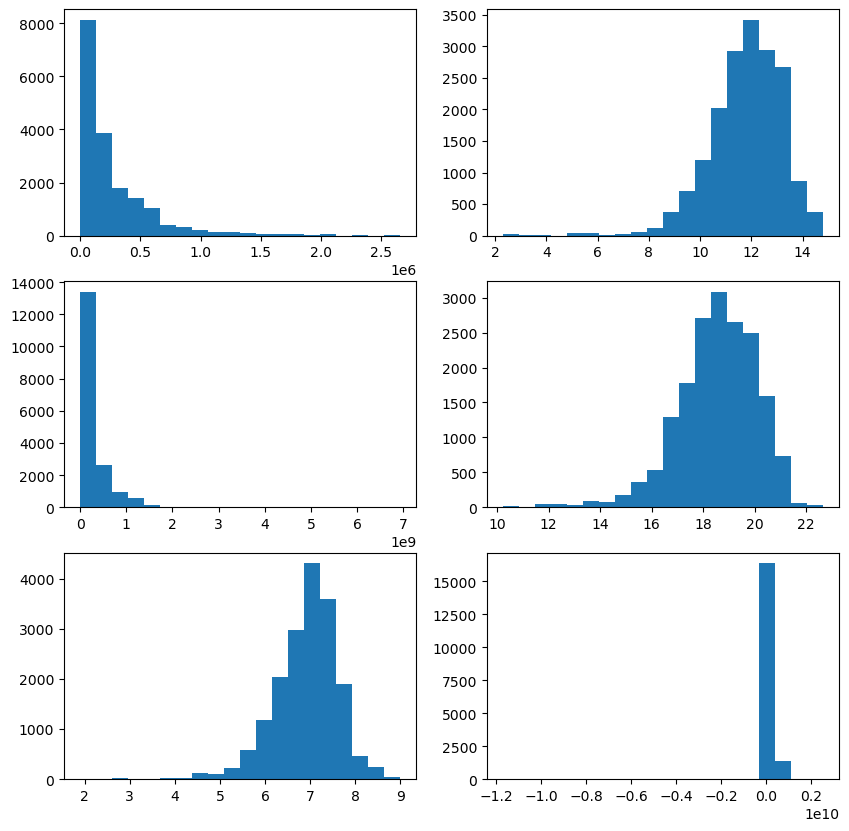

In [76]:
#observation of distributions
fig, ax = plt.subplots(3, 2, figsize=(10, 10)) #sharey=True)
ax[0, 0].hist(data['numVotes'], bins = 20)
ax[0, 1].hist(np.log(data['numVotes']), bins = 20)
ax[1, 0].hist(data['box_office_adj'], bins = 20)
ax[1, 1].hist(np.log(data['box_office_adj']), bins = 20)
ax[2, 1].hist(data['Profit'], bins = 20)
ax[2, 0].hist(data['averageRating'], bins = 20)
plt.show()

# Star score calculation

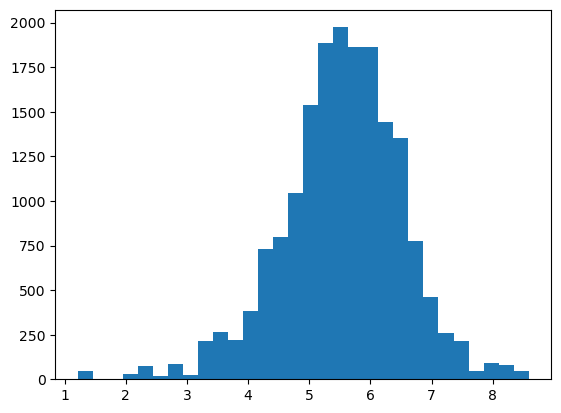

In [77]:
#first we need to deflate the imdb ratings by the amount of votes they've gotten

data['numVotes_factor'] = minMaxScale(np.log(data['numVotes']), m = 0)
data['averageRating_adj'] =  data['averageRating']* data['numVotes_factor']
plt.hist(data['averageRating_adj'], bins = 30) #adjusted to the number of votes
plt.show()

## normality tests of our logged box office & our imdb grade dataset
to see if our distributions are log normal and normal 

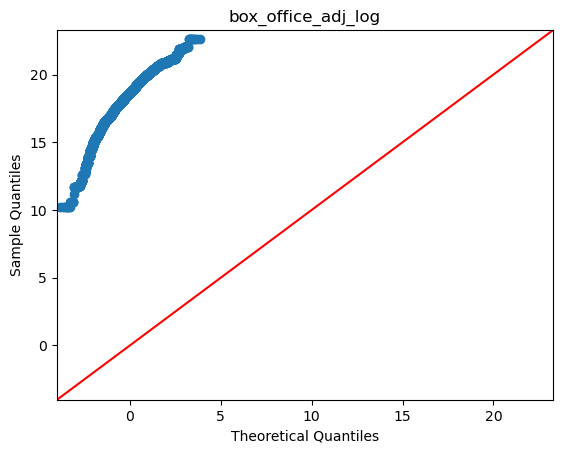

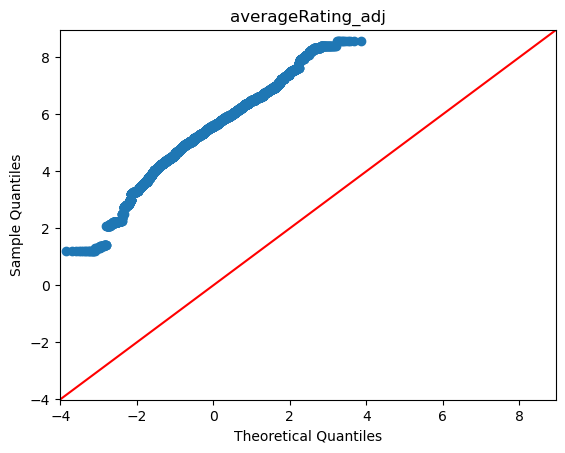

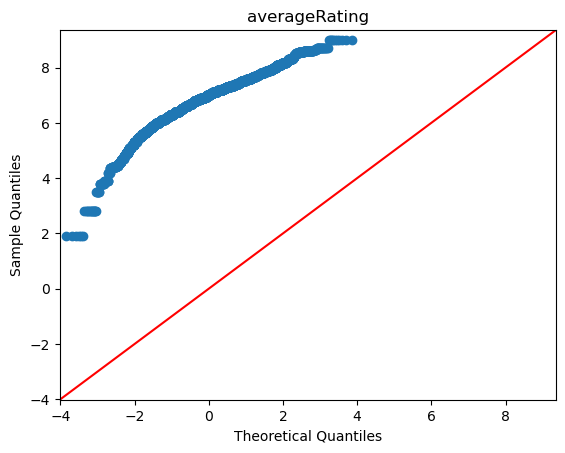

In [90]:
data['box_office_adj_log'] = np.log(data['box_office_adj'])
factors = ['box_office_adj_log', 'averageRating_adj', 'averageRating']

for factor in factors: 
    sm.qqplot(data[factor], line='45')
    plt.title(factor)
plt.show()

In [92]:
from scipy.stats import kstest

for factor in factors: 
    print(factor + ' normality = ', kstest(data[factor], 'norm'))

box_office_adj_log normality =  KstestResult(statistic=1.0, pvalue=0.0)
averageRating_adj normality =  KstestResult(statistic=0.9875167619011279, pvalue=0.0)
averageRating normality =  KstestResult(statistic=0.9985894485516578, pvalue=0.0)


#### Star scores to the latest date of the dataset (milestone P2) will do longitudinal star scores for P3

In [100]:
data['actor'] = data["Actor_name"].apply(lambda x : '_'.join(x.split()))
star_scores = pd.DataFrame(data['actor'].drop_duplicates().reset_index(drop = True))

In [101]:
for idx, actor in enumerate(star_scores['actor']):
    
    ds = data[data['actor'] == actor]
    star_scores.loc[idx, 'rev_sum'] = ds['box_office_adj'].sum()
    star_scores.loc[idx, 'grade_sum'] = ds['averageRating_adj'].sum()
    star_scores.loc[idx, 'appearances'] = len(ds)

In [104]:
star_scores['score'] = np.log(star_scores['rev_sum'] * star_scores['grade_sum'])
star_scores['score_epfl'] = (minMaxScale(star_scores['score']) * 5) + 1
star_scores.head(3)

,actor,rev_sum,grade_sum,appearances,score_new,score,score_epfl
0,Elmer_Clifton,1.250000e+09,4.791714,1.0,22.513298,22.513298,4.296256
1,Robert_Harron,1.250000e+09,4.791714,1.0,22.513298,22.513298,4.296256
2,Walter_Long,1.250000e+09,4.791714,1.0,22.513298,22.513298,4.296256


In [108]:
len(star_scores.query('appearances == 1'))/len(star_scores) #63% of actors have 1 movie

0.6306925207756233

(array([   5.,   11.,   33.,   31.,   31.,  103.,  201.,  333.,  785.,
        1143., 1371., 1313., 1175.,  966.,  661.,  430.,  245.,  125.,
          50.,   13.]),
 array([1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 , 2.75, 3.  , 3.25, 3.5 ,
        3.75, 4.  , 4.25, 4.5 , 4.75, 5.  , 5.25, 5.5 , 5.75, 6.  ]),
 <BarContainer object of 20 artists>)

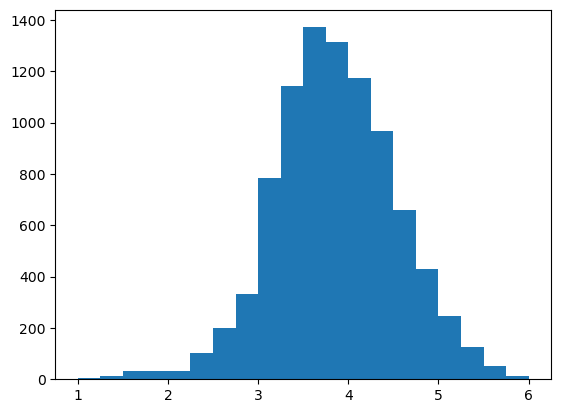

In [111]:
plt.hist(star_scores['score_epfl'], bins = 20)

In [114]:
top_actors = star_scores.sort_values(by = 'score_epfl', ascending = False).reset_index(drop = True)
top_actors.head(20)

,actor,rev_sum,grade_sum,appearances,score_new,score,score_epfl
0,Frank_Welker,9.137108e+09,163.999411,31.0,28.035473,28.035473,6.000000
1,Samuel_L._Jackson,9.075276e+09,148.968995,24.0,27.932558,27.932558,5.968248
2,Jim_Cummings,9.429944e+09,132.912448,26.0,27.856847,27.856847,5.944889
3,Tom_Hanks,9.544658e+09,125.541434,20.0,27.811883,27.811883,5.931017
4,Arnold_Schwarzenegger,7.306784e+09,138.148098,25.0,27.640395,27.640395,5.878108
5,Conrad_Vernon,1.065787e+10,86.890961,16.0,27.554218,27.554218,5.851520
6,John_Ratzenberger,9.635897e+09,86.008222,14.0,27.443204,27.443204,5.817269
7,Eddie_Murphy,8.381623e+09,97.442344,22.0,27.428568,27.428568,5.812753
8,Gary_Oldman,7.918840e+09,99.107305,16.0,27.388714,27.388714,5.800457
9,Alan_Rickman,9.031818e+09,83.949362,14.0,27.354233,27.354233,5.789819
